# Introducción a las Redes Neuronales Convolucionales

Las redes neuronales convolucionales (CNNs) son un tipo de red neuronal especialmente eficaz para tareas de reconocimiento de imágenes y procesamiento de datos con estructura de cuadrícula, como señales de audio o imágenes. Aprovechan patrones espaciales locales mediante la aplicación de operaciones de convolución, lo que las hace ideales para extraer características relevantes de las imágenes.

En esta clase, utilizaremos el conjunto de datos **FashionMNIST**, que es una versión moderna del clásico MNIST, pero en lugar de dígitos escritos a mano, contiene imágenes de artículos de moda en 10 categorías diferentes.

### Exploración del Conjunto de Datos**
Comencemos explorando el conjunto de datos mostrando una matriz de 4x4 imágenes con sus respectivas etiquetas.

100%|██████████| 26421880/26421880 [00:00<00:00, 28374432.55it/s]


Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 29515/29515 [00:00<00:00, 660144.31it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 4422102/4422102 [00:00<00:00, 12242319.27it/s]


Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



100%|██████████| 5148/5148 [00:00<?, ?it/s]


Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



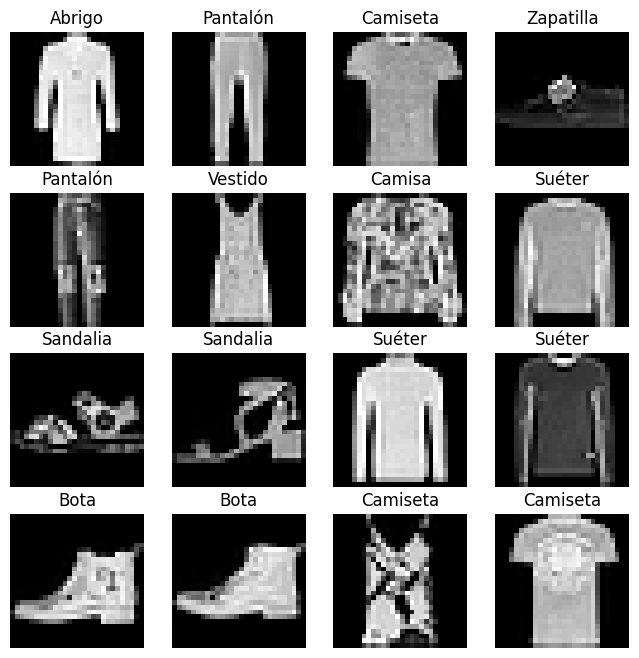

In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Definir las transformaciones para normalizar los datos
transform = transforms.Compose([transforms.ToTensor()])

# Descargar y cargar el conjunto de datos de entrenamiento
train_dataset = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)

# Mapeo de etiquetas a nombres de categorías
labels_map = {
    0: 'Camiseta',
    1: 'Pantalón',
    2: 'Suéter',
    3: 'Vestido',
    4: 'Abrigo',
    5: 'Sandalia',
    6: 'Camisa',
    7: 'Zapatilla',
    8: 'Bolso',
    9: 'Bota'
}

# Mostrar una matriz de 4x4 imágenes
figure = plt.figure(figsize=(8, 8))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()



**Construcción de la Red Neuronal Convolucional**

Ahora, definamos una red neuronal convolucional sencilla con dos capas convolucionales usando PyTorch.



In [3]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Primera capa convolucional
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # Segunda capa convolucional
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        # Capa de pooling
        self.pool = nn.MaxPool2d(2, 2)
        # Capa totalmente conectada
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        # Capa de salida
        self.fc2 = nn.Linear(128, 10)
        # relu
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))# Aplicar ReLU después de la primera convolución
        x = self.pool(x)            # Aplicar pooling
        x = self.relu(self.conv2(x))# Aplicar ReLU después de la segunda convolución
        x = self.pool(x)            # Aplicar pooling
        x = x.view(-1, 64 * 7 * 7)  # Aplanar el tensor
        x = self.relu(self.fc1(x))  # Aplicar ReLU después de la capa totalmente conectada
        x = self.fc2(x)             # Capa de salida
        return x



**Preparación para el Entrenamiento**

Configuramos el optimizador, la función de pérdida y los loaders de datos.



In [4]:
from torch.utils.data import DataLoader

# Definir los loaders de datos
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Cargar el conjunto de datos de prueba
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instanciar la red neuronal
model = CNN()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [10]:
from model_layers_visualizer import visualize
input_shape = (1, 28, 28)
visualize(model, input_shape, 'localhost', 8000)

Modelo enviado exitosamente al servidor.



**Entrenamiento del Modelo**

Entrenamos el modelo durante un número determinado de épocas, registrando las pérdidas y precisiones para cada época.



In [5]:
num_epochs = 10
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        # Reiniciar gradientes
        optimizer.zero_grad()
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backward pass y optimización
        loss.backward()
        optimizer.step()
        # Calcular métricas
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # Validación
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    test_losses.append(test_loss / len(test_loader))
    test_accuracies.append(100 * correct / total)

    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {train_losses[-1]:.4f}, Precisión: {train_accuracies[-1]:.2f}%")


Época [1/10], Pérdida: 0.4622, Precisión: 83.13%
Época [2/10], Pérdida: 0.2971, Precisión: 89.17%
Época [3/10], Pérdida: 0.2512, Precisión: 90.81%
Época [4/10], Pérdida: 0.2211, Precisión: 91.87%
Época [5/10], Pérdida: 0.1970, Precisión: 92.80%
Época [6/10], Pérdida: 0.1745, Precisión: 93.56%
Época [7/10], Pérdida: 0.1553, Precisión: 94.26%
Época [8/10], Pérdida: 0.1361, Precisión: 94.97%
Época [9/10], Pérdida: 0.1195, Precisión: 95.56%
Época [10/10], Pérdida: 0.1032, Precisión: 96.20%



**Curvas de Entrenamiento y Validación**

Pintamos las pérdidas y precisiones para visualizar el rendimiento del modelo.



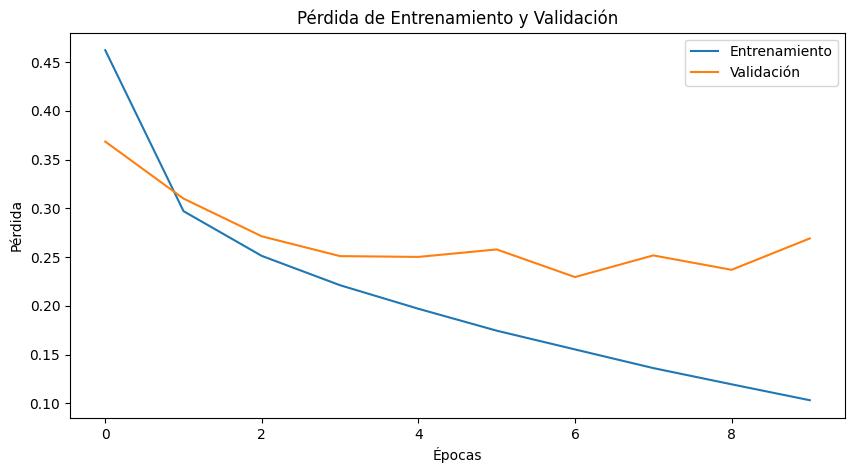

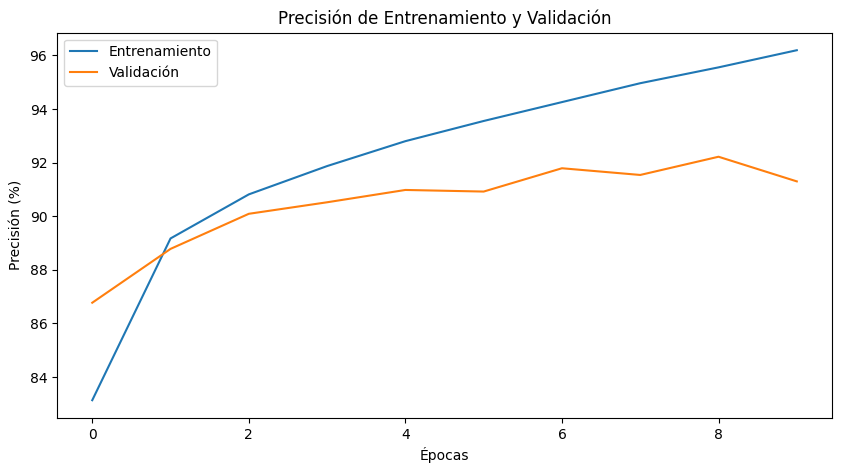

In [6]:
import matplotlib.pyplot as plt

# Plotear al pérdida
plt.figure(figsize=(10,5))
plt.title("Pérdida de Entrenamiento y Validación")
plt.plot(train_losses,label="Entrenamiento")
plt.plot(test_losses,label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

# Plotear la precisión
plt.figure(figsize=(10,5))
plt.title("Precisión de Entrenamiento y Validación")
plt.plot(train_accuracies,label="Entrenamiento")
plt.plot(test_accuracies,label="Validación")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.legend()
plt.show()



**Matriz de Confusión**

Creamos una matriz de confusión para analizar en detalle el rendimiento del modelo en cada clase.



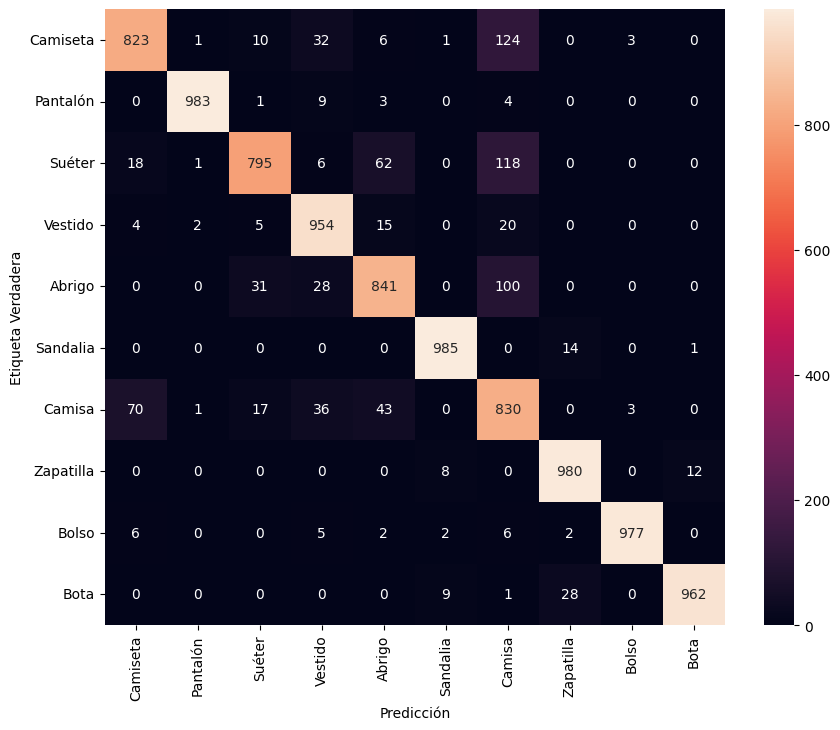

In [7]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Obtener todas las predicciones y etiquetas verdaderas
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Crear la matriz de confusión
cm = confusion_matrix(all_labels, all_preds)

# Graficar la matriz de confusión
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels_map.values(), yticklabels=labels_map.values())
plt.xlabel('Predicción')
plt.ylabel('Etiqueta Verdadera')
plt.show()



**Aplicación del Modelo en Imágenes de Prueba**

Mostramos una matriz de 4x4 imágenes de prueba con sus predicciones y etiquetas verdaderas.



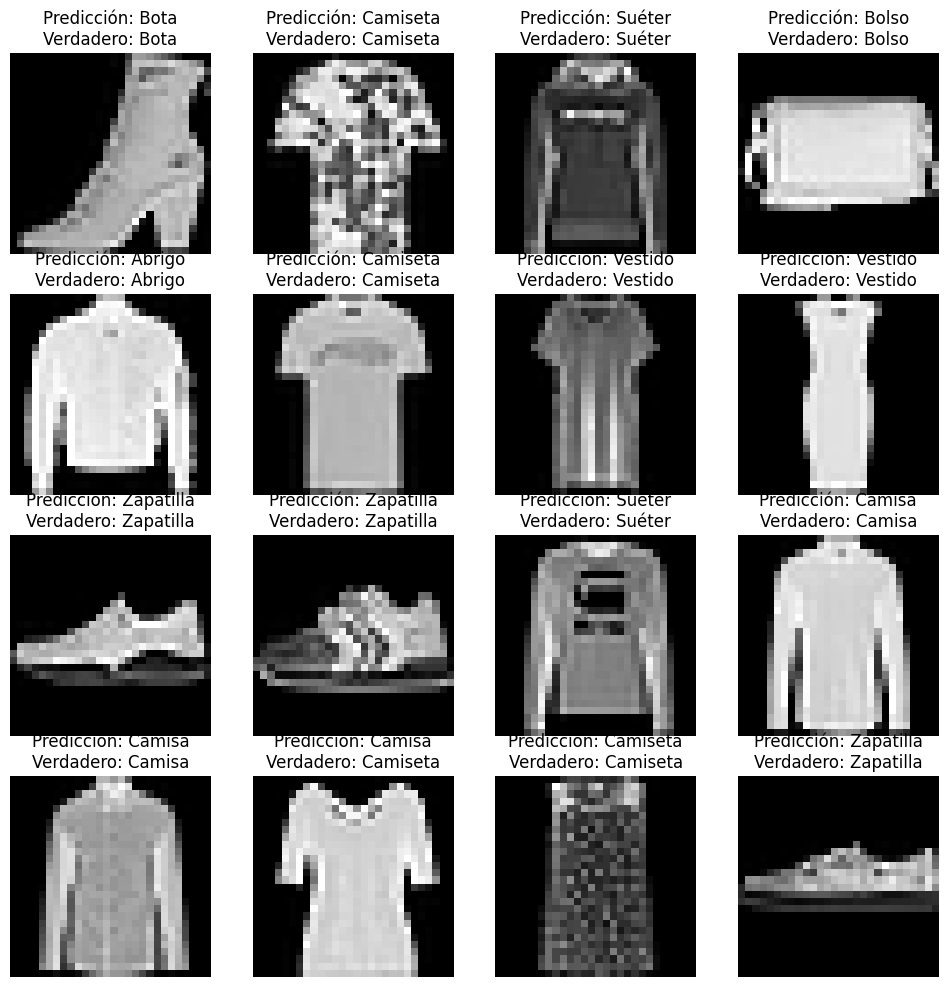

In [9]:
# Seleccionar 16 imágenes de prueba al azar
indices = np.random.choice(len(test_dataset), size=16, replace=False)
images, labels = zip(*[test_dataset[i] for i in indices])
images = torch.stack(images)
labels = torch.tensor(labels)

# Obtener predicciones
model.eval()
with torch.no_grad():
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

# Mostrar las imágenes con las predicciones y etiquetas verdaderas
figure = plt.figure(figsize=(12, 12))
cols, rows = 4, 4
for i in range(len(images)):
    img = images[i]
    label = labels[i]
    pred = predicted[i]
    figure.add_subplot(rows, cols, i+1)
    title = f"Predicción: {labels_map[pred.item()]}\nVerdadero: {labels_map[label.item()]}"
    plt.title(title)
    plt.axis('off')
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()
